In [1]:
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torchvision.transforms as transforms
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Define Mongolian Unicode vocabulary
vocab = list(range(0x1800, 0x180F)) + list(range(0x1810, 0x181A)) + list(range(0x1820, 0x1879)) + \
        list(range(0x1880, 0x18AB)) + [0x202F]

vocab = ["<blank>", "<pad>", " "] + [chr(v) for v in vocab]  # <blank> token at index 0

# Create character-to-index mappings
idx2char = {idx: char for idx, char in enumerate(vocab)}
char2idx = {char: idx for idx, char in idx2char.items()}

# Add <unk> token for unknown characters
n = len(idx2char)
idx2char[n] = "<unk>"
char2idx["<unk>"] = n

# Add other special characters
idx2char[n+1] = '?'
char2idx['?'] = n+1
char2idx['︖'] = n+1
char2idx['？'] = n+1

# Define padding token
PAD_TOKEN = 1  # Common choice for PyTorch loss functions

# Text to IDs function with <unk> for unknown characters
def text_to_ids(text, max_length=None):
    ids = [char2idx.get(char, char2idx["<unk>"]) for char in text]  # Use <unk> for unknown chars
    
    if max_length is not None:
        if len(ids) < max_length:
            ids += [PAD_TOKEN] * (max_length - len(ids))  # Pad the sequence
        else:
            ids = ids[:max_length]  # Truncate the sequence if it's too long

    return ids

# IDs to text function
def ids_to_text(ids):
    decoded_text = []
    for idx in ids:
        if idx == 0:
            continue  # Ignore blank token (<blank>)
        elif idx > 0:  # For other characters in the vocab
            decoded_text.append(idx2char.get(idx, ''))  # Avoid missing chars

    return "".join(decoded_text)


In [3]:
class MongolianTextImageDataset(Dataset):
    def __init__(self, image_paths, labels, max_text_length=50, transform=None, pad_text=True):
        """
        Initializes the dataset.
        :param image_paths: List of paths to the image files.
        :param labels: List of corresponding text labels.
        :param max_text_length: Maximum length of text sequences. Padding will be applied if enabled.
        :param transform: Optional transformation to apply to the images.
        :param pad_text: Whether to pad text sequences to max_text_length.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.max_text_length = max_text_length
        self.transform = transform
        self.pad_text = pad_text
        self.pad_token = char2idx.get("<pad>", PAD_TOKEN)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches an image and its corresponding text.

        :param idx: Index of the image-text pair.
        :return: Tuple (image_tensor, text_ids) where text_ids is a tensor of token indices.
        """
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply the transformation to the image (if any)
        if self.transform:
            image = self.transform(image)

        text = self.labels[idx]
        # Convert text to token IDs
        text_ids = text_to_ids(text)

        # Apply padding or truncation if enabled
        if self.pad_text:
            if len(text_ids) < self.max_text_length:
                text_ids.extend([self.pad_token] * (self.max_text_length - len(text_ids)))  # Pad
            else:
                text_ids = text_ids[:self.max_text_length]  # Truncate

        return image, torch.tensor(text_ids, dtype=torch.long)


In [4]:
image_paths = []
image_labels = []
# df = pd.read_csv("../dataset/mini_qa_images/mini_qa.csv")
# for index, row in df.iterrows():
#     # if(index%20==0):
#     #     print(f"{index} out of 100")
#     text = row['question']
#     path = f"../dataset/mini_qa_images/question/{index}.png"
#     image_paths.append(path)
#     image_labels.append(text)


with open('../munguu/image_labels.json') as f:
    data = json.load(f)

for el in data:
    if len(el['label'])>=5 and len(el['label'])<=20:
        image_paths.append(f"../munguu/{el['image_path']}")
        image_labels.append(el['label'])

# # Define any image preprocessing steps (e.g., normalization)

input_shape = (32, 256)

transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.Grayscale(num_output_channels=1),  # Converts to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),  # Adjusted to single channel
])
# Create the dataset



In [5]:



# Split dataset into train and validation sets (80% train, 20% validation)
train_dataset, val_dataset = train_test_split(list(zip(image_paths, image_labels)), test_size=0.2)

# Create datasets for training and validation
train_dataset = MongolianTextImageDataset([item[0] for item in train_dataset], [item[1] for item in train_dataset], max_text_length=20, transform=transform, pad_text=True)
val_dataset = MongolianTextImageDataset([item[0] for item in val_dataset], [item[1] for item in val_dataset], max_text_length=20, transform=transform, pad_text=True)

# Create DataLoaders for batching
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [6]:
# class CTCModel(nn.Module):
#     def __init__(self,input_channels=1, hidden_dim=256):
#         """
#         Initializes the CTC model.
        
#         :param idx2num: Dictionary mapping indices to tokens (including special tokens).
#         :param input_channels: Number of input channels (e.g., 1 for grayscale).
#         :param hidden_dim: Hidden dimension size for the RNN.
#         """
#         super(CTCModel, self).__init__()
#         self.num_classes = len(idx2char)  # Number of output classes
        
#         # CNN feature extractor
#         self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # RNN (bidirectional LSTM) for sequence modeling
#         # The input_size is 128 * (pooled height); note that we assume the pooling is applied on height.
#         # Here, after 3 poolings, the height is reduced by a factor of 2^3=8.
#         # Since the model input height is 128, the effective height becomes 128 // 8 = 16.
#         # Therefore, the features at each timestep will be 128 * 16.
#         # Alternatively, if you prefer to treat the width dimension as time steps and collapse channel and height,
#         # you can reshape accordingly.
#         self.rnn = nn.LSTM(input_size=128 * 16, hidden_size=hidden_dim, num_layers=2,
#                            bidirectional=True, batch_first=True)
        
#         # Fully connected layer to project RNN outputs to num_classes
#         self.fc = nn.Linear(hidden_dim * 2, self.num_classes)  # *2 for bidirectional

#     def forward(self, x):
#         """
#         Forward pass.
        
#         :param x: Input image tensor of shape (batch_size, channels, height, width)
#         :return: Logits of shape (batch_size, seq_length, num_classes)
#         """
#         # Pass through convolutional layers with pooling
#         x = self.pool(F.relu(self.conv1(x)))  # (batch, 32, H/2, W/2)
#         x = self.pool(F.relu(self.conv2(x)))  # (batch, 64, H/4, W/4)
#         x = self.pool(F.relu(self.conv3(x)))  # (batch, 128, H/8, W/8)
        
#         # Here, x.shape = (batch_size, 128, H', W')
#         # We assume H' is the reduced height and W' is the width dimension to be treated as time steps.
#         # For OCR, we often treat the width dimension as the time axis.
#         # First, permute to (batch_size, W', channels, H')
#         x = x.permute(0, 3, 1, 2)
#         # Now, flatten the (channels, H') dimensions: each time step has features of size 128 * H'
#         b, w, c, h = x.size()
#         x = x.reshape(b, w, c * h)
        
#         # Pass through the RNN layers
#         rnn_out, _ = self.rnn(x)  # rnn_out shape: (batch_size, seq_length, hidden_dim*2)
        
#         # Map RNN outputs to logits for each class at each timestep
#         logits = self.fc(rnn_out)  # (batch_size, seq_length, num_classes)
#         return logits

class CRNN(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=256):
        """
        Initializes the CRNN model.
        
        :param input_channels: Number of input channels (e.g., 1 for grayscale).
        :param hidden_dim: Hidden dimension size for the RNN.
        """
        super(CRNN, self).__init__()
        self.num_classes = len(idx2char)  # Number of output classes

        # CNN feature extractor
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)

        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.batchnorm7 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces H/W by 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))  # Reduces H but keeps W
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))  

        # BiLSTM for sequence modeling
        self.rnn = nn.LSTM(input_size=512 * 1, hidden_size=hidden_dim, num_layers=2,
                           bidirectional=True, batch_first=True)
        
        # Fully connected layer to map RNN outputs to num_classes
        self.fc = nn.Linear(hidden_dim * 2, self.num_classes)  # *2 for bidirectional

    def forward(self, x):
        """
        Forward pass.
        
        :param x: Input image tensor of shape (batch_size, channels, height, width)
        :return: Logits of shape (batch_size, seq_length, num_classes)
        """
        # Convolutional feature extraction
        x = self.pool1(F.relu(self.conv1(x)))  
        x = self.pool2(F.relu(self.conv2(x)))  
        x = F.relu(self.batchnorm3(self.conv3(x)))  
        x = self.pool3(F.relu(self.conv4(x)))  
        x = F.relu(self.batchnorm5(self.conv5(x)))  
        x = self.pool4(F.relu(self.conv6(x)))  
        x = F.relu(self.batchnorm7(self.conv7(x)))  

        # Reshape to fit into RNN
        b, c, h, w = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch_size, width, channels, height)
        x = x.reshape(b, w, c * h)  # Flatten channels and height

        # Pass through BiLSTM
        rnn_out, _ = self.rnn(x)  

        # Fully connected layer for character prediction
        logits = self.fc(rnn_out)  # Shape: (batch_size, seq_length, num_classes)

        return logits

In [7]:
def decode_predictions(predictions):
    """
    Decode model predictions to text strings.
    
    Args:
        predictions: Tensor of indices
    
    Returns:
        List of decoded strings
    """
    texts = []
    for pred in predictions:
        # Get the highest probability character at each timestep
        pred_indices = torch.argmax(pred, dim=1).cpu().numpy()
        
        # Remove repeated characters
        collapsed = []
        prev = -1
        for p in pred_indices:
            if p != prev and p != 0:  # Skip blanks
                collapsed.append(p)
            prev = p
        
        # Convert indices to characters
        text = ''.join([idx2char.get(idx, '') for idx in collapsed if idx != 1])  # Skip pad tokens
        texts.append(text)
    return texts

def calculate_wer(reference, hypothesis):
    """
    Calculate Word Error Rate without external libraries.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Word Error Rate as a float
    """
    total_words = 0
    word_errors = 0
    
    for ref, hyp in zip(reference, hypothesis):
        # Split into words
        ref_words = ref.split()
        hyp_words = hyp.split()
        
        # Simple word-level comparison
        total_words += len(ref_words)
        
        # Count substitutions, insertions, and deletions
        if len(hyp_words) >= len(ref_words):
            # Substitutions and insertions
            for i in range(len(ref_words)):
                if i >= len(hyp_words) or ref_words[i] != hyp_words[i]:
                    word_errors += 1
            # Extra insertions
            word_errors += max(0, len(hyp_words) - len(ref_words))
        else:
            # Substitutions and deletions
            for i in range(len(hyp_words)):
                if ref_words[i] != hyp_words[i]:
                    word_errors += 1
            # Extra deletions
            word_errors += len(ref_words) - len(hyp_words)
    
    return word_errors / total_words if total_words > 0 else 0

def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate without external libraries.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Character Error Rate as a float
    """
    total_chars = 0
    char_errors = 0
    
    for ref, hyp in zip(reference, hypothesis):
        total_chars += len(ref)
        
        # Simplified Levenshtein distance calculation
        # Initialize matrix
        matrix = [[0 for _ in range(len(hyp) + 1)] for _ in range(len(ref) + 1)]
        
        # Initialize first row and column
        for i in range(len(ref) + 1):
            matrix[i][0] = i
        for j in range(len(hyp) + 1):
            matrix[0][j] = j
        
        # Fill matrix
        for i in range(1, len(ref) + 1):
            for j in range(1, len(hyp) + 1):
                if ref[i-1] == hyp[j-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(
                        matrix[i-1][j] + 1,      # deletion
                        matrix[i][j-1] + 1,      # insertion
                        matrix[i-1][j-1] + 1     # substitution
                    )
        
        char_errors += matrix[len(ref)][len(hyp)]
    
    return char_errors / total_chars if total_chars > 0 else 0


In [8]:
input_channels = 1  # Grayscale
model = CRNN( input_channels=input_channels)

# Example input (batch_size=8, channels=1, height=128, width=512)
input_shape = (32, 256)
input_tensor = torch.randn(8, input_channels, input_shape[0], input_shape[1])
output = model(input_tensor)

print("Output shape:", output.shape)  # Expected: (8, seq_length, num_classes)

Output shape: torch.Size([8, 65, 163])


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_channels = 1  # Grayscale
# model = CRNN( input_channels=input_channels)
# model = model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)

# num_epochs = 10
# loss_history = []
# val_loss_history = []

# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss = 0.0
#     for batch_idx, (images, targets) in enumerate(train_dataloader):
#         # Move images and targets to device (GPU or CPU)
#         images = images.to(device)
#         targets = targets.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         outputs = outputs.permute(1, 0, 2)
#         outputs = torch.log_softmax(outputs, dim=2)
#         batch_size = images.size(0)
#         seq_length = outputs.size(0)
#         input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

#         target_lengths = (targets != 1).sum(dim=1).to(device)

#         flattened_targets = []
#         for i in range(batch_size):
#             non_pad = targets[i][targets[i] != 1]
#             flattened_targets.extend(non_pad.tolist())
#         flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

#         loss = ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     loss_history.append(epoch_loss / len(train_dataloader))

#     # Validation loop
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for batch_idx, (images, targets) in enumerate(eval_dataloader):
#             images = images.to(device)
#             targets = targets.to(device)

#             outputs = model(images)
#             outputs = outputs.permute(1, 0, 2)
#             outputs = torch.log_softmax(outputs, dim=2)
#             batch_size = images.size(0)
#             seq_length = outputs.size(0)
#             input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

#             target_lengths = (targets != 1).sum(dim=1).to(device)

#             flattened_targets = []
#             for i in range(batch_size):
#                 non_pad = targets[i][targets[i] != 1]
#                 flattened_targets.extend(non_pad.tolist())
#             flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

#             val_loss += ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths).item()

#     val_loss_history.append(val_loss / len(eval_dataloader))
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}, Val Loss: {val_loss / len(eval_dataloader):.4f}")

Epoch 1/10, Loss: 5.2588, Val Loss: 3.2378
Epoch 2/10, Loss: 3.3762, Val Loss: 3.2405
Epoch 3/10, Loss: 3.3233, Val Loss: 3.1817
Epoch 4/10, Loss: 3.2374, Val Loss: 3.2355
Epoch 5/10, Loss: 3.1869, Val Loss: 3.1342
Epoch 6/10, Loss: 3.1428, Val Loss: 3.2829
Epoch 7/10, Loss: 3.0629, Val Loss: 3.1018
Epoch 8/10, Loss: 3.0154, Val Loss: 3.1622
Epoch 9/10, Loss: 2.9925, Val Loss: 3.1624
Epoch 10/10, Loss: 2.9187, Val Loss: 3.1618


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels = 1  # Grayscale
model = CRNN( input_channels=input_channels)
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-5)
ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)

num_epochs = 100
loss_history = []
val_loss_history = []
wer_history = []
cer_history = []




for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_dataloader):
        # Move images and targets to device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        outputs = torch.log_softmax(outputs, dim=2)
        batch_size = images.size(0)
        seq_length = outputs.size(0)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

        target_lengths = (targets != 1).sum(dim=1).to(device)

        flattened_targets = []
        for i in range(batch_size):
            non_pad = targets[i][targets[i] != 1]
            flattened_targets.extend(non_pad.tolist())
        flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

        loss = ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / len(train_dataloader))

    # Validation loop with WER and CER calculation
    model.eval()
    val_loss = 0.0
    all_ground_truth = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(eval_dataloader):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)
            outputs = torch.log_softmax(outputs, dim=2) 
            batch_size = images.size(0)
            seq_length = outputs.size(0)
            input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

            target_lengths = (targets != 1).sum(dim=1).to(device)

            flattened_targets = []
            for i in range(batch_size):
                non_pad = targets[i][targets[i] != PAD_TOKEN]
                flattened_targets.extend(non_pad.tolist())
            flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

            val_loss += ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths).item()
            
            # Decode predictions
            pred_texts = decode_predictions(outputs.permute(1, 0, 2))
            
            # Decode ground truth
            gt_texts = []
            for i in range(batch_size):
                gt = targets[i][targets[i] != 1].cpu().numpy()
                gt_text = ''.join([idx2char.get(idx, '') for idx in gt if idx != 1])
                gt_texts.append(gt_text)
            
            all_ground_truth.extend(gt_texts)
            all_predictions.extend(pred_texts)

    val_loss_history.append(val_loss / len(eval_dataloader))
    # print(all_ground_truth, all_predictions)
    # Calculate WER
    epoch_wer = calculate_wer(all_ground_truth, all_predictions)
    
    # Calculate CER
    epoch_cer = calculate_cer(all_ground_truth, all_predictions)
    
    wer_history.append(epoch_wer)
    cer_history.append(epoch_cer)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}, "
          f"Val Loss: {val_loss / len(eval_dataloader):.4f}, WER: {epoch_wer:.4f}, CER: {epoch_cer:.4f}")




['ᠢᠷᠡᠭᠡᠳ', 'ᠰᠠᠶᠢᠨ', 'ᠲᠦᠯᠦᠪᠯᠡᠵᠤ', 'ᠵᠢᠷᠠᠭᠠᠯ', 'ᠬᠤᠳᠠᠯᠳᠤᠳᠠᠭ', 'ᠪᠠᠶᠢᠬᠤ', 'ᠢᠷᠡᠬᠦ', 'ᠪᠠᠶᠢᠭᠰᠠᠭᠠᠷ', 'ᠮᠠᠨᠠᠷᠠᠭᠤᠯᠴᠢᠬᠠᠪᠠ', 'ᠬᠤᠷᠢᠮ', 'ᠤᠲᠠᠰᠤ', 'ᠰᠠᠭᠤᠬᠤ', 'ᠪᠣᠯᠤᠭᠰᠠᠨ', 'ᠬᠥᠮᠦᠨ', 'ᠨᠢᠰᠬᠡᠭᠴᠢ', 'ᠵᠠᠬᠢᠷᠤᠭᠴᠢ', 'ᠳᠠᠷᠠᠭᠠᠬᠢ', 'ᠡᠭᠦᠯᠡ', 'ᠲᠤᠰᠬᠠᠯ', 'ᠭᠡᠨᠡᠳᠲᠡ', 'ᠪᠣᠬᠢᠷ'] ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch 1/100, Loss: 36.6604, Val Loss: 24.8600, WER: 1.0000, CER: 1.0000
['ᠢᠷᠡᠭᠡᠳ', 'ᠰᠠᠶᠢᠨ', 'ᠲᠦᠯᠦᠪᠯᠡᠵᠤ', 'ᠵᠢᠷᠠᠭᠠᠯ', 'ᠬᠤᠳᠠᠯᠳᠤᠳᠠᠭ', 'ᠪᠠᠶᠢᠬᠤ', 'ᠢᠷᠡᠬᠦ', 'ᠪᠠᠶᠢᠭᠰᠠᠭᠠᠷ', 'ᠮᠠᠨᠠᠷᠠᠭᠤᠯᠴᠢᠬᠠᠪᠠ', 'ᠬᠤᠷᠢᠮ', 'ᠤᠲᠠᠰᠤ', 'ᠰᠠᠭᠤᠬᠤ', 'ᠪᠣᠯᠤᠭᠰᠠᠨ', 'ᠬᠥᠮᠦᠨ', 'ᠨᠢᠰᠬᠡᠭᠴᠢ', 'ᠵᠠᠬᠢᠷᠤᠭᠴᠢ', 'ᠳᠠᠷᠠᠭᠠᠬᠢ', 'ᠡᠭᠦᠯᠡ', 'ᠲᠤᠰᠬᠠᠯ', 'ᠭᠡᠨᠡᠳᠲᠡ', 'ᠪᠣᠬᠢᠷ'] ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Epoch 2/100, Loss: 8.5754, Val Loss: 5.2837, WER: 1.0000, CER: 1.0000
['ᠢᠷᠡᠭᠡᠳ', 'ᠰᠠᠶᠢᠨ', 'ᠲᠦᠯᠦᠪᠯᠡᠵᠤ', 'ᠵᠢᠷᠠᠭᠠᠯ', 'ᠬᠤᠳᠠᠯᠳᠤᠳᠠᠭ', 'ᠪᠠᠶᠢᠬᠤ', 'ᠢᠷᠡᠬᠦ', 'ᠪᠠᠶᠢᠭᠰᠠᠭᠠᠷ', 'ᠮᠠᠨᠠᠷᠠᠭᠤᠯᠴᠢᠬᠠᠪᠠ', 'ᠬᠤᠷᠢᠮ', 'ᠤᠲᠠᠰᠤ', 'ᠰᠠᠭᠤᠬᠤ', 'ᠪᠣᠯᠤᠭᠰᠠᠨ', 'ᠬᠥᠮᠦᠨ', 'ᠨᠢᠰᠬᠡᠭᠴᠢ', 'ᠵᠠᠬᠢᠷᠤᠭᠴᠢ', 'ᠳᠠᠷᠠᠭᠠᠬᠢ', 'ᠡᠭᠦᠯᠡ', 'ᠲᠤᠰᠬᠠᠯ', 'ᠭᠡ

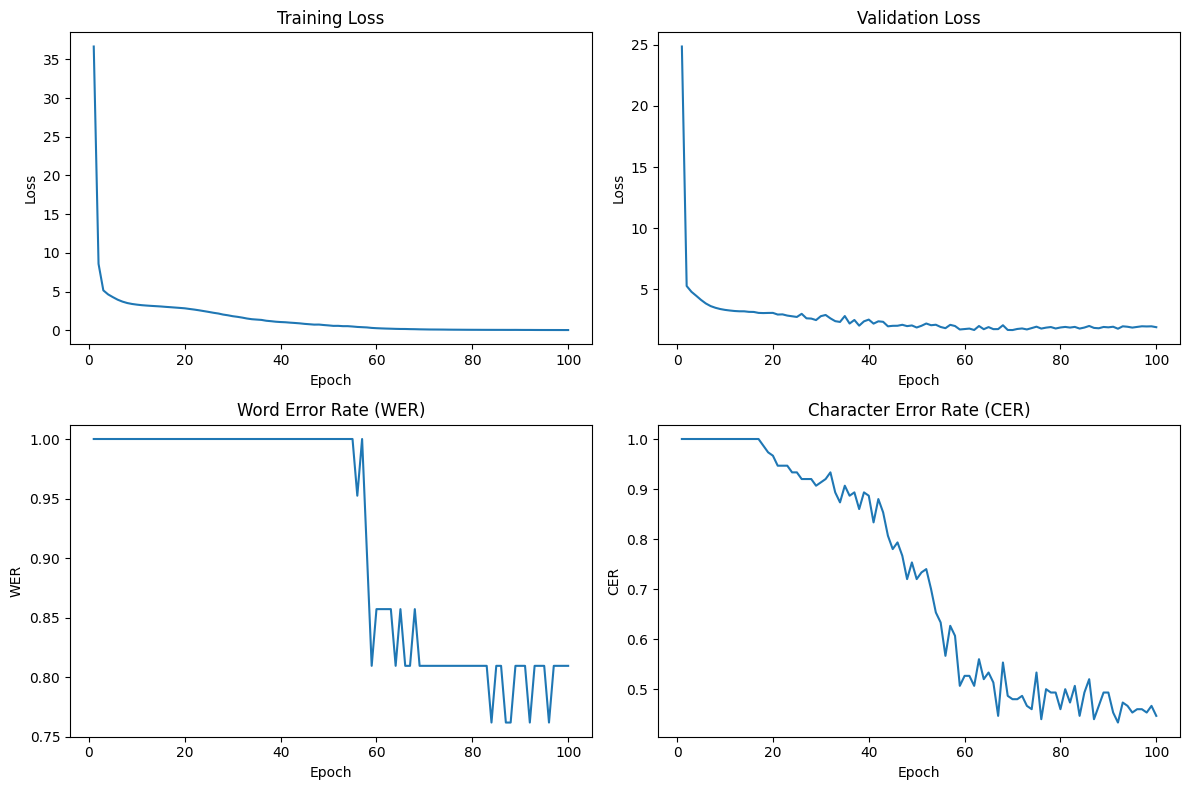

In [14]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs+1), loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs+1), val_loss_history)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, num_epochs+1), wer_history)
plt.title('Word Error Rate (WER)')
plt.xlabel('Epoch')
plt.ylabel('WER')

plt.subplot(2, 2, 4)
plt.plot(range(1, num_epochs+1), cer_history)
plt.title('Character Error Rate (CER)')
plt.xlabel('Epoch')
plt.ylabel('CER')

plt.tight_layout()
plt.savefig('ocr_metrics.png')
plt.show()

In [15]:
# Save the model's state_dict
torch.save(model.state_dict(), 'crnn_model.pth')


In [17]:
# Load the saved model (if not already loaded)
model = CRNN(input_channels=input_channels)
model.load_state_dict(torch.load('crnn_model.pth'))
model = model.to(device)  # Make sure the model is on the correct device

# Set the model to evaluation mode
model.eval()

# Initialize variables to track loss, WER, and CER
val_loss = 0.0
all_ground_truth = []
all_predictions = []

with torch.no_grad():
    # Iterate over the evaluation dataset
    for batch_idx, (images, targets) in enumerate(eval_dataloader):
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        outputs = torch.log_softmax(outputs, dim=2)

        batch_size = images.size(0)
        seq_length = outputs.size(0)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)
        target_lengths = (targets != 1).sum(dim=1).to(device)

        flattened_targets = []
        for i in range(batch_size):
            non_pad = targets[i][targets[i] != 1]
            flattened_targets.extend(non_pad.tolist())
        flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

        # Calculate CTC loss
        val_loss += ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths).item()

        # Decode predictions
        pred_texts = decode_predictions(outputs.permute(1, 0, 2))

        # Decode ground truth
        gt_texts = []
        for i in range(batch_size):
            gt = targets[i][targets[i] != 1].cpu().numpy()
            gt_text = ''.join([idx2char.get(idx, '') for idx in gt if idx != 1])
            gt_texts.append(gt_text)

        all_ground_truth.extend(gt_texts)
        all_predictions.extend(pred_texts)

# Calculate WER
epoch_wer = calculate_wer(all_ground_truth, all_predictions)

# Calculate CER
epoch_cer = calculate_cer(all_ground_truth, all_predictions)

# Print the results
print(f"Validation Loss: {val_loss / len(eval_dataloader):.4f}")
print(f"WER: {epoch_wer:.4f}")
print(f"CER: {epoch_cer:.4f}")


Validation Loss: 1.9177
WER: 0.8095
CER: 0.4467


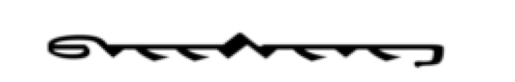

In [82]:

image_tensor = images[0].cpu()

# Step 1: Remove the channel dimension (1, 32, 256) -> (32, 256)
image_tensor = image_tensor.squeeze(0)  # Removes the first dimension if it's 1

# Step 2: Convert the tensor to a NumPy array
image_np = image_tensor.numpy()

# Step 3: Display the image using Matplotlib
plt.imshow(image_np, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Hide axes
plt.show()